In [2]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae,surv_gan,surv_vae
#from utils.metrics import log_rank, cox_estimation


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [3]:
n_samples = 600
n_features_bytype = 4
n_features_multiplier = 3 

In [4]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0

In [5]:
control, treated, types = simulation(beta_features, treatment_effect , n_samples , independent = False, surv_type = 'surv_piecewise', n_features_bytype = 4, 
                n_features_multiplier = 3, nnz = 3 , p_treated = 0.5,a_T=2,
                a_C = 2., lamb_C = 6., lamb_C_indpt = 2.5, data_types_create = True)
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [6]:
print(np.mean(control['censor']),np.mean(treated['censor']))

0.8606811145510835 0.8628158844765343


In [7]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [8]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

D

In [9]:
D = np.sum(control['censor'])+np.sum(treated['censor'])
print(D)

517


In [10]:
alpha = 0.05
p_treated = 0.5
treatment_effect = 0.2
expected_power = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2))

In [11]:
expected_power

np.float64(0.6231633058815294)

## Generation

In [12]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [13]:
data_init_control_encoded

tensor([[ 0.1593,  0.3693,  0.5103,  ...,  0.0000,  1.3611,  0.0000],
        [-0.5321, -1.2464, -1.6574,  ...,  1.0000,  0.6238,  1.0000],
        [-0.0407, -0.8763, -0.5367,  ...,  1.0000,  1.5375,  1.0000],
        ...,
        [ 1.4327,  1.5732,  1.3753,  ...,  0.0000,  3.8799,  1.0000],
        [-1.1395, -0.1851, -1.3472,  ...,  1.0000,  1.1084,  1.0000],
        [ 1.8968,  0.2319,  0.2151,  ...,  0.0000,  6.2644,  1.0000]])

In [14]:
data_init_control_encoded.shape

torch.Size([323, 18])

In [15]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [16]:
feat_types_dict

[{'': '0', 'name': 'feat1', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '1', 'name': 'feat2', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '2', 'name': 'feat3', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '3', 'name': 'feat4', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '4', 'name': 'feat5', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '5', 'name': 'feat6', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '6', 'name': 'feat7', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '7', 'name': 'feat8', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '8', 'name': 'feat9', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '9', 'name': 'feat10', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '10', 'name': 'feat11', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '11', 'name': 'feat12', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '12',
  'name': 'survcens',
  'type': 'surv_piecewise',
  'dim': '2',
  'nclass': ''}]

In [17]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

In [18]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
#visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [19]:
names_cont = []
names_pos = []
names_cat = []
for x in range(1, n_features_bytype   + 1):
            names_pos.append("feat{0}".format(x + n_features_bytype))
            names_cat.append("feat{0}".format(x + 2 * n_features_bytype))

table1 = TableOne(df_init, categorical=names_cat, continuous=names_cont, 
                  groupby='treatment', nonnormal=names_pos, pval=True)
print(table1)

                          Grouped by treatment                                                     
                                       Missing        Overall              0              1 P-Value
n                                                         600            323            277        
feat1, mean (SD)                             0      0.0 (1.0)     -0.0 (1.0)      0.1 (1.0)   0.214
feat2, mean (SD)                             0      0.0 (0.9)      0.0 (0.9)     -0.0 (0.9)   0.756
feat3, mean (SD)                             0     -0.0 (1.0)     -0.0 (1.0)     -0.0 (0.9)   0.955
feat4, mean (SD)                             0      0.0 (1.0)     -0.0 (1.0)      0.0 (0.9)   0.767
feat5, median [Q1,Q3]                        0  0.7 [0.3,1.1]  0.7 [0.3,1.1]  0.7 [0.3,1.2]   0.964
feat6, median [Q1,Q3]                        0  0.7 [0.3,1.2]  0.7 [0.3,1.2]  0.6 [0.3,1.1]   0.935
feat7, median [Q1,Q3]                        0  0.7 [0.3,1.1]  0.7 [0.3,1.1]  0.7 [0.3,1.2]   0.801


In [20]:


# the datasets used for training is data_init_control
n_generated_dataset = 10
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [21]:
data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                        time_to_event_column="time", n_generated_sample=n_generated_dataset)
data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                        time_to_event_column="time", n_generated_sample=n_generated_dataset)

[2025-05-22T13:16:53.045180+0200][70617][CRITICAL] Error importing TabularGoggle: No module named 'dgl'
[2025-05-22T13:16:53.046449+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:16:54.258248+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▊                                                          | 899/10000 [00:25<04:20, 34.97it/s]
[2025-05-22T13:17:21.216341+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:17:21.228749+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊  

NameError: name 'sel_idx' is not defined

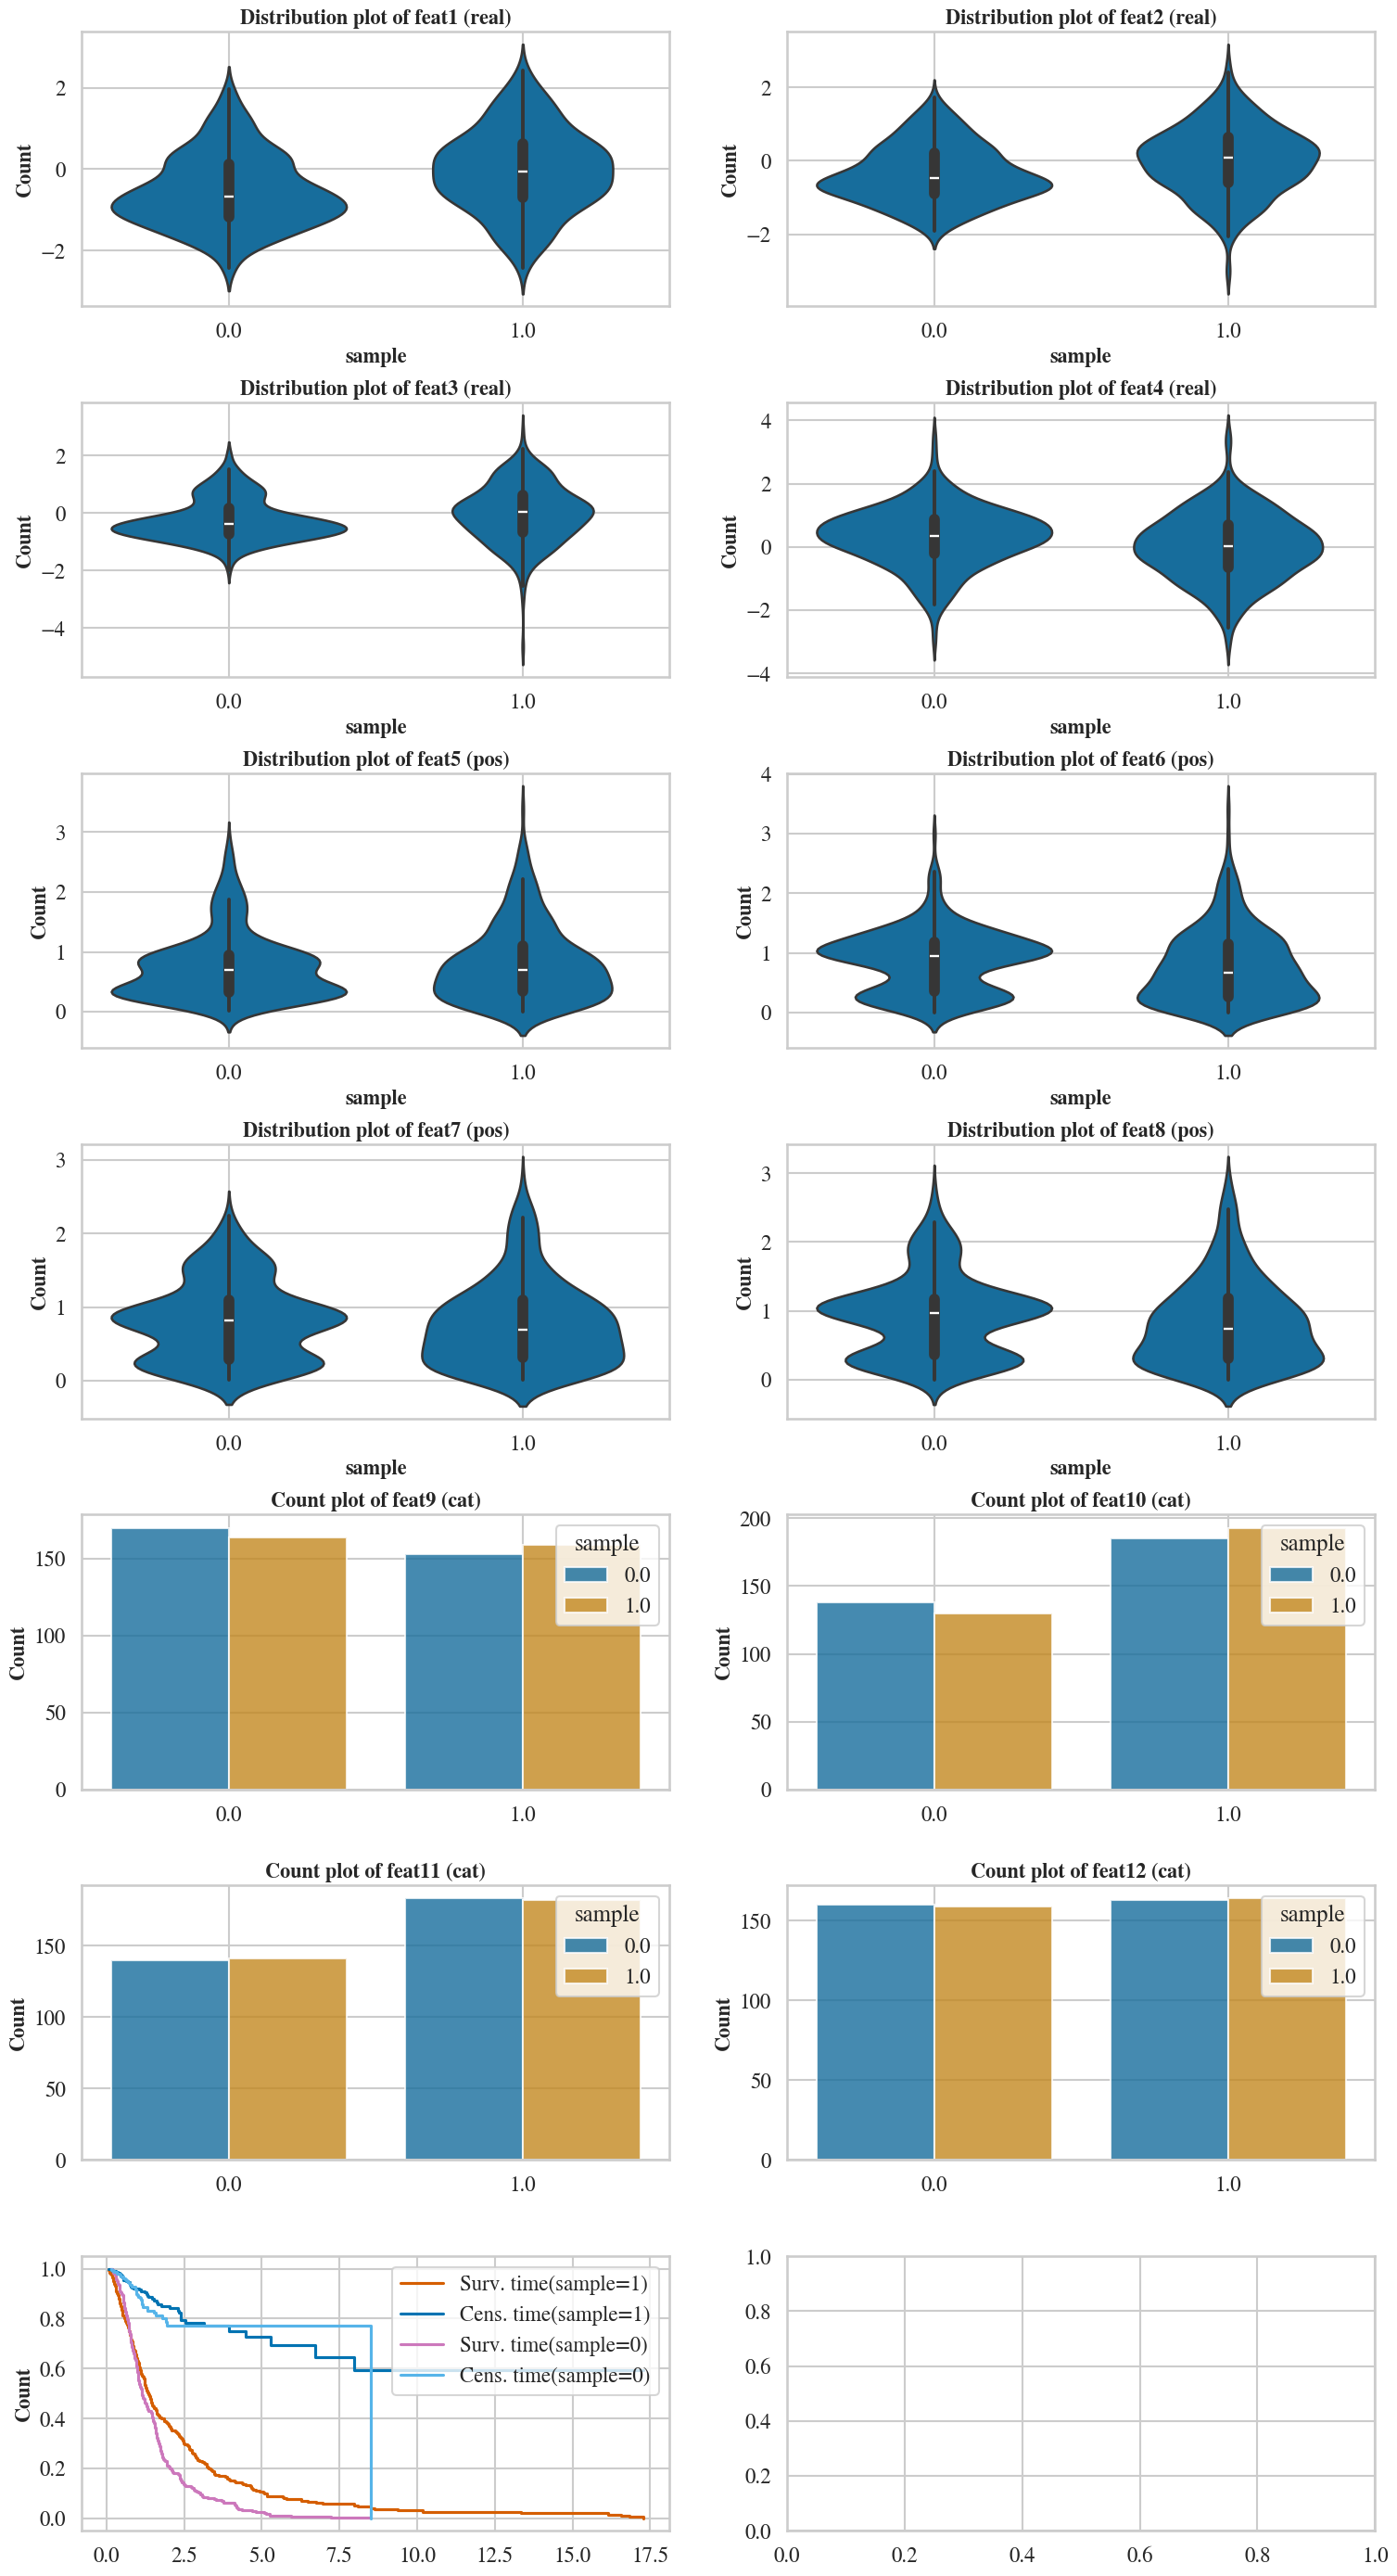

In [23]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=fnames)
df_init_control_ext['sample'] = 1

sel_idx = 0
df_gen_control_ext_sel = pd.DataFrame(data_gen_control_survgan[sel_idx].numpy(), columns=fnames)
df_gen_control_ext_sel['sample'] = 0

# Save original values before overwriting
#tmp = df_gen_control_ext_sel[['time', 'censor']].copy()

# Replace 'time' with row-wise minimum
#df_gen_control_ext_sel['time'] = tmp.min(axis=1)

# Replace 'censor' with column name of the minimum ('time' or 'censor')
#df_gen_control_ext_sel['censor'] = 1* (tmp.idxmin(axis=1)=='time')
#df_gen_control_ext_sel[]

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [24]:
intervals

[(0.0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 1.25)]

## Replication

In [25]:
n_generated_dataset = 20
dataset_name = "Simulations"

In [26]:
alphas = np.arange(0,0.4,0.1)
print(alphas)

[0.  0.1 0.2 0.3]


In [ ]:
M = 100
log_p_value = []
log_p_value_gen_hivae = []
log_p_value_aug_hivae = []
log_p_value_gen_survgan = []
log_p_value_aug_survgan = []
log_p_value_gen_survvae = []
log_p_value_aug_survvae = []

simu_num = []
treat_coef = []
D_init = []
D_eff_hivae = []
D_eff_survgan = []
D_eff_survvae = []
for t in alphas:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated, types = simulation(beta_features, treatment_effect , n_samples, independent = True, surv_type = 'surv_weibull')
        n_control_init = control.shape[0]
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')

        n_control_to_generate = n_control_init - control.shape[0]
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
    
        # Generate synthetic data
        data_gen_control_hivae = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
        
        data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                        time_to_event_column="time", n_generated_sample=n_generated_dataset)
    
        
        data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                        time_to_event_column="time", n_generated_sample=n_generated_dataset)

        # compute log-rank pvalues
        for i in range(n_generated_dataset):
            log_p_value.append(p_value_init)
            simu_num.append(m)
            D_init.append(control['censor'].sum()+treated['censor'].sum())

            ### HIVAE ###
            df_gen_control_hivae = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)
            df_gen_control_hivae['treatment'] = 0
            
            df_gen_control_aug_hivae = pd.DataFrame(torch.cat([data_init_control, data_gen_control_hivae[i]]).numpy(), columns=fnames)
            df_gen_control_aug_hivae['treatment'] = 0


            
            D_eff_hivae.append(df_gen_control_aug_hivae['censor'].sum()+treated['censor'].sum())
            
            p_value_gen_hivae = compute_logrank_test(df_gen_control_hivae, treated)
            log_p_value_gen_hivae.append(p_value_gen_hivae)

            p_value_aug_hivae = compute_logrank_test(df_gen_control_aug_hivae, treated)
            log_p_value_aug_hivae.append(p_value_aug_hivae)

            ### SURVGAN ###
                        
            df_gen_control_survgan = pd.DataFrame(data_gen_control_survgan[i].numpy(), columns=fnames)
            df_gen_control_survgan['treatment'] = 0
            
            df_gen_control_aug_survgan = pd.DataFrame(torch.cat([data_init_control, 
                                                                 torch.tensor(data_gen_control_survgan[i].numpy())]).numpy(), columns=fnames)
    
            df_gen_control_aug_survgan['treatment'] = 0


            
            D_eff_survgan.append(df_gen_control_aug_survgan['censor'].sum()+treated['censor'].sum())
            
            p_value_gen_survgan = compute_logrank_test(df_gen_control_survgan, treated)
            log_p_value_gen_survgan.append(p_value_gen_survgan)

            p_value_aug_survgan = compute_logrank_test(df_gen_control_aug_survgan, treated)
            log_p_value_aug_survgan.append(p_value_aug_survgan)

            ### SURVVAE ###

            df_gen_control_survvae = pd.DataFrame(data_gen_control_survvae[i].numpy(), columns=fnames)
            df_gen_control_survvae['treatment'] = 0
            
            df_gen_control_aug_survvae = pd.DataFrame(torch.cat([data_init_control, 
                                                                 torch.tensor(data_gen_control_survvae[i].numpy())]).numpy(), columns=fnames)
    
            df_gen_control_aug_survvae['treatment'] = 0


            
            D_eff_survvae.append(df_gen_control_aug_survvae['censor'].sum()+treated['censor'].sum())
            
            p_value_gen_survvae = compute_logrank_test(df_gen_control_survvae, treated)
            log_p_value_gen_survvae.append(p_value_gen_survvae)

            p_value_aug_survvae = compute_logrank_test(df_gen_control_aug_survvae, treated)
            log_p_value_aug_survvae.append(p_value_aug_survvae)
            
            
            treat_coef.append(treatment_effect)
            

0


[2025-05-22T13:23:03.141142+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:23:03.191221+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|██████▍                                                         | 999/10000 [00:28<04:16, 35.10it/s]
[2025-05-22T13:23:33.138947+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:23:33.151251+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 55%|███████████████████████████████████▊                             | 550/1000 [00:22<00:18, 24.40it/s]
[2025-05-22T13:24:04.287634+

10


[2025-05-22T13:33:40.777602+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:33:40.861816+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:27<06:09, 25.16it/s]
[2025-05-22T13:34:10.810066+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:34:10.827036+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 70%|█████████████████████████████████████████████▌                   | 700/1000 [00:38<00:16, 18.22it/s]
[2025-05-22T13:35:01.141575+

20


[2025-05-22T13:46:03.383671+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:46:03.450439+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:30<06:46, 22.89it/s]
[2025-05-22T13:46:36.157559+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:46:36.174069+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:23<00:35, 16.67it/s]
[2025-05-22T13:47:13.465389+

30


[2025-05-22T13:58:01.641443+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:58:01.721416+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  3%|██▏                                                             | 349/10000 [00:14<06:43, 23.93it/s]
[2025-05-22T13:58:18.399489+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T13:58:18.416320+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:20<00:30, 19.70it/s]
[2025-05-22T13:58:50.372726+

40


[2025-05-22T14:09:31.262763+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T14:09:31.323040+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▊                                                           | 749/10000 [00:31<06:24, 24.04it/s]
[2025-05-22T14:10:04.723498+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-22T14:10:04.742575+0200][70617][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:18<00:35, 18.54it/s]
[2025-05-22T14:10:36.338520+

In [ ]:
pd.DataFrame(torch.cat([data_init_control, torch.tensor(data_gen_control_survgan[sel_idx].numpy())]).numpy(), columns=fnames)

In [ ]:
torch.tensor(data_gen_control_survgan[sel_idx].numpy())

In [ ]:
type(data_init_control)

In [ ]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value,  "treat_coef" : treat_coef, "D_init" : D_init,
                        "log_pvalue_gen_hivae" : log_p_value_gen_hivae ,
                        "log_pvalue_aug_hivae" : log_p_value_aug_hivae , "D_eff_hivae" : D_eff_hivae,
                       "log_pvalue_gen_survgan" : log_p_value_gen_survgan ,
                        "log_pvalue_aug_survgan" : log_p_value_aug_survgan , "D_eff_survgan" : D_eff_survgan,
                        "log_pvalue_gen_survvae" : log_p_value_gen_survvae ,
                        "log_pvalue_aug_survvae" : log_p_value_aug_survvae , "D_eff_survvae" : D_eff_survvae})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen_hivae"] = results['log_pvalue_gen_hivae'] > -np.log(0.05)
results["reject_H0_aug_hivae"] = results['log_pvalue_aug_hivae'] > -np.log(0.05)

results["reject_H0_gen_survgan"] = results['log_pvalue_gen_survgan'] > -np.log(0.05)
results["reject_H0_aug_survgan"] = results['log_pvalue_aug_survgan'] > -np.log(0.05)


results["reject_H0_gen_survvae"] = results['log_pvalue_gen_survvae'] > -np.log(0.05)
results["reject_H0_aug_survvae"] = results['log_pvalue_aug_survvae'] > -np.log(0.05)



In [ ]:
results.to_csv("./dataset/" + dataset_name + "/results_aug_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [ ]:
alpha = 0.05
p_treated = 0.5
D_means_init = results.groupby("treat_coef").mean()["D_init"].to_numpy()
D_means_eff = results.groupby("treat_coef").mean()["D_eff_hivae"].to_numpy()
expected_power_init = []
expected_power_eff = []
for i in np.arange(alphas.shape[0]):
    treat_E = alphas[i]
    D = D_means_init[i]
    expected_power_init.append(norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treat_E)**2 ) - norm.ppf(1 - alpha/2)))
    D = D_means_eff[i]
    expected_power_eff.append(norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treat_E)**2 ) - norm.ppf(1 - alpha/2)))

In [ ]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen_hivae = results.groupby("treat_coef").mean()["reject_H0_gen_hivae"].to_numpy()
puiss_aug_hivae = results.groupby("treat_coef").mean()["reject_H0_aug_hivae"].to_numpy()
puiss_gen_survgan = results.groupby("treat_coef").mean()["reject_H0_gen_survgan"].to_numpy()
puiss_aug_survgan = results.groupby("treat_coef").mean()["reject_H0_aug_survgan"].to_numpy()
puiss_gen_survvae = results.groupby("treat_coef").mean()["reject_H0_gen_survvae"].to_numpy()
puiss_aug_survvae = results.groupby("treat_coef").mean()["reject_H0_aug_survvae"].to_numpy()


#puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(alphas,puiss_init,label = "All init.")
plt.scatter(alphas,puiss_gen_hivae,label = "All gen. hivae")
plt.scatter(alphas,puiss_aug_hivae,label = "All aug. hivae")

plt.scatter(alphas,puiss_gen_hivae,label = "All gen. survgan")
plt.scatter(alphas,puiss_aug_hivae,label = "All aug. survgan")


plt.scatter(alphas,puiss_gen_hivae,label = "All gen. survvae")
plt.scatter(alphas,puiss_aug_hivae,label = "All aug. survvae")

#plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
#plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
plt.plot(alphas,expected_power_init,label = "Expected level/power",label = "Exp. power init")
plt.plot(alphas,expected_power_eff,label = "Expected level/power",label = "Exp. power eff")

plt.legend()
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

array([514., 509.])

array([514., 509.])

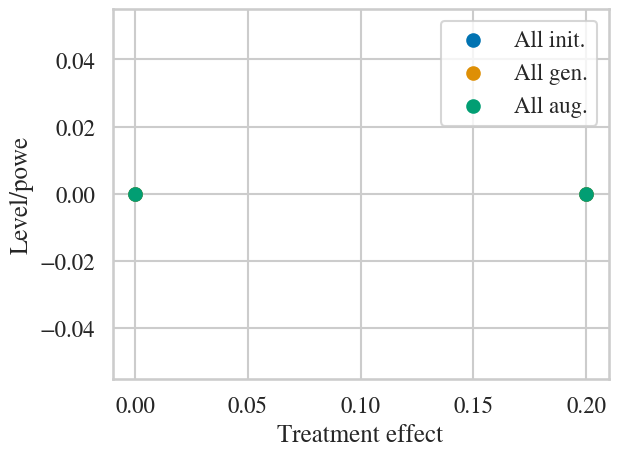

In [43]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("treat_coef").mean()["reject_H0_gen"].to_numpy()
puiss_aug = results.groupby("treat_coef").mean()["reject_H0_aug"].to_numpy()
#puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(alphas,puiss_init,label = "All init.")
plt.scatter(alphas,puiss_gen,label = "All gen.")
plt.scatter(alphas,puiss_aug,label = "All aug.")
#plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
#plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
#plt.plot(alphas,expected_power,label = "Expected level/power")
#plt.plot(np.arange(alphas.min(),alphas.max() + 0.01,0.01),expected_power,label = "Expected level/power")
plt.legend()
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

## TODO point size should be proportional to sample size

#### Subsampling

In [ ]:
M = 100
log_p_value = []
log_p_value_gen = []
log_p_value_aug = []
simu_num = []
treat_coef = []
p_choices = np.arange(0.2,0.6,0.2) 
D_init = []
D_eff = []
for t in alphas:
    treatment_effect = t
    for p in p_choices:
        for m in np.arange(M):
            if m % 10 == 0:
                print(m)
            control, treated, types = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull")
            control = control.sample(frac=1-p, replace=False)
            control = control.drop(columns='treatment')
            treated = treated.drop(columns='treatment')
    
            D =  n_samples - np.sum(control['censor']) - np.sum(treated['censor'])
            D_init.append(D)
            
            data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
            data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
            
            
            control.to_csv(data_file_control,index=False , header=False)
            treated.to_csv(data_file_treated,index=False , header=False)
            
            df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
            df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
            
            T_surv = torch.Tensor(df_init_control.time)
            T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
            n_intervals = 5
            T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
            T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
            intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
            
            p_value_init = compute_logrank_test(control, treated)
        
            
        
            # Load and transform control data
            data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                         feat_types_file_control, 
                                                                                                                         miss_file, true_miss_file)
            data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
            
            # Load and transform treated data
            data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                     miss_file, true_miss_file)
            data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
        
            data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                          true_miss_mask_control, feat_types_file_control, feat_types_dict, 
                                            n_generated_dataset, verbose=False)
            
            for i in range(n_generated_dataset):
                D_init.append(control['censor'].sum()+treated['censor'].sum())
        
                
                df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
                df_gen_control = df_gen_control.sample(frac=p, replace=False)
                df_gen_control['treatment'] = 0
                
                df_gen_control_aug = pd.DataFrame(torch.cat([data_init_control, data_gen_control[i]]).numpy(), columns=fnames)
                df_gen_control_aug['treatment'] = 0
                log_p_value.append(p_value_init)
                simu_num.append(m)
                
                D_eff.append(df_gen_control_aug['censor'].sum()+treated['censor'].sum())
                
                p_value_gen = compute_logrank_test(df_gen_control, treated)
                log_p_value_gen.append(p_value_gen)
    
                p_value_aug = compute_logrank_test(df_gen_control_aug, treated)
                log_p_value_aug.append(p_value_aug)
                
                treat_coef.append(treatment_effect)

                 

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0


In [ ]:
results.to_csv("./dataset/" + dataset_name + "/results_sub_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")